# Custom Object Detection Training with YOLOS

In this tutorial, we assemble a dataset and train a custom YOLOS model to recognize the objects in our dataset. To do so we will take the following steps:

* Gather a dataset of images and label our dataset
* Export our dataset to YOLOS
* Train YOLOS to recognize the objects in our dataset
* Log our training metrics to Weights & Biases
* Evaluate YOLOS model's performance
* Run test inference to view our model at work
* Sample images for active learning so our model improves the more we use it


This notebook is derived from inspiration from [NielsRogge's originial](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/YOLOS/Fine_tuning_YOLOS_for_object_detection_on_custom_dataset_(balloon).ipynb), which in turn derived inspiration from [this notebook finetuning DETR](https://github.com/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb)

Also thanks to Morgan McGuire from `wandb` for work on the `wandb` spectacular logging, and Philipp Schmid at HuggingFace for direction and infrastructure for Sagemaker Serverless deployment.

![](https://i.imgur.com/GCzOU2N.png)



# Setup Environment

To get ready to train YOLOS, we first install `transformers` for the model and `pytorch-lightning` for the training routine.

For logging, we will log into `wandb` - Weights and Biases

For dataset and active learning, we will install `roboflow`

For model deployment, we will install AWS `sagemaker`

In [1]:
!pip install -q transformers==4.20.0
!pip install -q pytorch-lightning
!pip install -q wandb
!pip install -q roboflow

ROBOFLOW_API_KEY = "BbWC5ppO2riGs4B0iAvf"
 #obtain an API Key from your roboflow workspace's settings & treat it like a password

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 38.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 64.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 53.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 24.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... 

In [2]:
#AWS deployment login - if you are not deploying yet, you can comment these lines out
# !pip install sagemaker --upgrade -q
# !curl "https://awscli.amazonaws.com/awscli-exe-linux-x86_64.zip" -o "awscliv2.zip" 
# !unzip awscliv2.zip
# !sudo ./aws/install
# !aws configure set aws_access_key_id "YOUR AWS KEY"
# !aws configure set aws_secret_access_key "YOUR AWS SECRET KEY"
# !aws configure set default.region us-east-2

In [3]:
#To log our training metrics we need to log in to Weights & Biases with our API key, you can sign up for free here: https://wandb.ai/site
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Label, Process, and Download Dataset from Roboflow

In order to train our custom model, we need to assemble a dataset of representative images with bounding box annotations around the objects that we want to detect. And we need our dataset to be in COCO format.

In Roboflow, you can choose between three paths:

* Convert an existing dataset to COCO format. Roboflow supports over [30 object detection formats](https://roboflow.com/formats) for conversion.
* Upload raw images and annotate them in Roboflow with [Roboflow Annotate](https://docs.roboflow.com/annotate).
* Browse public object detections projects to start from on [Roboflow Universe](https://universe.roboflow.com/)

# Annotate

![](https://roboflow-darknet.s3.us-east-2.amazonaws.com/roboflow-annotate.gif)

# Version

![](https://roboflow-darknet.s3.us-east-2.amazonaws.com/robolfow-preprocessing.png)

In [4]:
#########Dataset Download###########
#TO GET DATASET DOWNLOAD VISIT https://app.roboflow.com/?model=YOLOS&ref=YOLOS
from roboflow import Roboflow
rf = Roboflow(api_key="BbWC5ppO2riGs4B0iAvf")
project = rf.workspace("thesis-vfvpg").project("knives-n-guns-april")
dataset = project.version(1).download("coco")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Knives-n-guns-april-1 in coco:: 100%|██████████| 9431/9431 [00:01<00:00, 8468.11it/s]


In [5]:
#where our dataset is
dataset.location

'/content/Knives-n-guns-april-1'

In [6]:
#Register dataset as torchvision CocoDetection
import torchvision
import os

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, feature_extractor, train=True):
        ann_file = os.path.join(img_folder, "_annotations.coco.json")
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)
        
        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target

from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained("hustvl/yolos-small", size=512, max_size=864)

train_dataset = CocoDetection(img_folder=(dataset.location + '/train'), feature_extractor=feature_extractor)
val_dataset = CocoDetection(img_folder=(dataset.location + '/valid'), feature_extractor=feature_extractor, train=False)

print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

Downloading:   0%|          | 0.00/275 [00:00<?, ?B/s]

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Number of training examples: 6603
Number of validation examples: 1878


Image n°2064


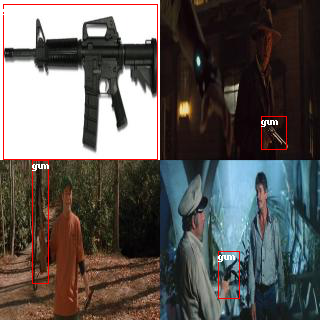

In [7]:
#Vizualize that our data has loaded correctly - You can hit this cell as many times as you want to vizualize how your training set has loaded
import numpy as np
import os
from PIL import Image, ImageDraw

# based on https://github.com/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb
image_ids = train_dataset.coco.getImgIds()
# let's pick a random image
image_id = image_ids[np.random.randint(0, len(image_ids))]
print('Image n°{}'.format(image_id))
image = train_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(dataset.location + '/train', image['file_name']))

annotations = train_dataset.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

for annotation in annotations:
  box = annotation['bbox']
  class_idx = annotation['category_id']
  x,y,w,h = tuple(box)
  draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
  draw.text((x, y), id2label[class_idx], fill='white')

image

In [8]:
#Setup dataloader for training loop

from torch.utils.data import DataLoader

def collate_fn(batch):
  pixel_values = [item[0] for item in batch]
  encoding = feature_extractor.pad(pixel_values, return_tensors="pt")
  labels = [item[1] for item in batch]
  batch = {}
  batch['pixel_values'] = encoding['pixel_values']
  batch['labels'] = labels
  return batch

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=1, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=1)
batch = next(iter(train_dataloader))

# Set Up YOLOS Training Configuration

In [9]:
# For our training configuration, we will start from the pretrained YOLOS-tiny model from 
# Hugging Face transformers

import pytorch_lightning as pl
from transformers import DetrConfig, AutoModelForObjectDetection
import torch

#we wrap our model around pytorch lightning for training
class YoloS(pl.LightningModule):

     def __init__(self, lr, weight_decay):
         super().__init__()
         # replace COCO classification head with custom head
         self.model = AutoModelForObjectDetection.from_pretrained("hustvl/yolos-tiny", 
                                                             num_labels=len(id2label),
                                                             ignore_mismatched_sizes=True)
         # see https://github.com/PyTorchLightning/pytorch-lightning/pull/1896
         self.lr = lr
         self.weight_decay = weight_decay
         self.save_hyperparameters()  # adding this will save the hyperparameters to W&B too

     def forward(self, pixel_values):
       outputs = self.model(pixel_values=pixel_values)

       return outputs
     
     def common_step(self, batch, batch_idx):
       pixel_values = batch["pixel_values"]
       labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

       outputs = self.model(pixel_values=pixel_values, labels=labels)

       loss = outputs.loss
       loss_dict = outputs.loss_dict

       return loss, loss_dict

     def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("train/loss", loss)  # logging metrics with a forward slash will ensure the train and validation metrics as split into 2 separate sections in the W&B workspace
        for k,v in loss_dict.items():
          self.log("train/" + k, v.item())  # logging metrics with a forward slash will ensure the train and validation metrics as split into 2 separate sections in the W&B workspace

        return loss

     def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        self.log("validation/loss", loss) # logging metrics with a forward slash will ensure the train and validation metrics as split into 2 separate sections in the W&B workspace
        for k,v in loss_dict.items():
          self.log("validation/" + k, v.item()) #  logging metrics with a forward slash will ensure the train and validation metrics as split into 2 separate sections in the W&B workspace

        return loss

     def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr,
                                  weight_decay=self.weight_decay)
        
        return optimizer

     def train_dataloader(self):
        return train_dataloader

     def val_dataloader(self):
        return val_dataloader

In [10]:
#initialize the model
model = YoloS(lr=2.5e-5, weight_decay=1e-4)

Downloading:   0%|          | 0.00/4.04k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/24.8M [00:00<?, ?B/s]

Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-tiny and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 192]) in the checkpoint and torch.Size([4, 192]) in the model instantiated
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Run Training of Custom YOLOS Detector

More epochs will fit the model tighter to your training set - for this toy example we only train for a few epochs

In [11]:
# import wandb
# #you can name your wandb project however you like, 
# #in this project you will be able to compare training runs
# wandb.init(project="my-test-project")
# from pytorch_lightning.loggers import WandbLogger
# from pytorch_lightning import Trainer

# wandb_logger = WandbLogger()

In [12]:
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint

# Name your wandb project and upload the final checkpoint to wandb, according to ModelCheckpoint
# Click on the output wandb run name below to see your metrics updating live in wandb
wandb_logger = WandbLogger(project='roboflow-yolos', log_model=True)

# Keep track of the checkpoint with the lowest validation loss
checkpoint_callback = ModelCheckpoint(monitor="validation/loss", mode="min")

wandb: Currently logged in as: sergiorodrigofernandeztesta (my_thesis5919). Use `wandb login --relogin` to force relogin


In [28]:
from pytorch_lightning import Trainer

#more epochs leads to a tighter fit of your model to your data.
#we set epochs=10 here for an example of quick training
trainer = Trainer(devices=1, accelerator="gpu", max_epochs=30, gradient_clip_val=0.1, accumulate_grad_batches=8, 
                  log_every_n_steps=5, logger=wandb_logger, callbacks=[checkpoint_callback]) #  checkpoint_callback to log model to W&B at end of training and changed log_every_n_steps=5 to generate better charts
    
trainer.fit(model)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                    | Params
--------------------------------------------------
0 | model | YolosForObjectDetection | 6.5 M 

UsageError: ignored

# Evaluate Custom YOLOS Model

We evaluate our newly trained model using DETR eval code



In [14]:
#clean up torch tensors before eval so your gpu memory doesn't crash!
torch.cuda.empty_cache()

In [15]:
#we borrow the eval scripts from the DETR repo as they provide similar functionality to what we need to calculate mAP
!git clone https://github.com/facebookresearch/detr.git
%cd /content/detr

Cloning into 'detr'...
remote: Enumerating objects: 263, done.
remote: Total 263 (delta 0), reused 0 (delta 0), pack-reused 263
Receiving objects: 100% (263/263), 12.88 MiB | 26.11 MiB/s, done.
Resolving deltas: 100% (122/122), done.
/content/detr


In [16]:
from datasets import get_coco_api_from_dataset

base_ds = get_coco_api_from_dataset(val_dataset) # this is actually just calling the coco attribute

In [17]:
from datasets.coco_eval import CocoEvaluator
from tqdm.notebook import tqdm

iou_types = ['bbox']
coco_evaluator = CocoEvaluator(base_ds, iou_types) # initialize evaluator with ground truths

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
model.eval()

print("Running evaluation...")

for idx, batch in enumerate(tqdm(val_dataloader)):
    # get the inputs
    pixel_values = batch["pixel_values"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]] # these are in DETR format, resized + normalized

    # forward pass
    outputs = model.model(pixel_values=pixel_values)

    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = feature_extractor.post_process(outputs, orig_target_sizes) # convert outputs of model to COCO api
    res = {target['image_id'].item(): output for target, output in zip(labels, results)}
    coco_evaluator.update(res)

coco_evaluator.synchronize_between_processes()
coco_evaluator.accumulate()
coco_evaluator.summarize()
#the evaluation here prints out mean average precision details
#learn more - https://blog.roboflow.com/mean-average-precision/

Running evaluation...


  0%|          | 0/1878 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=1.75s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.376
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.763
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.324
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.209
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.418
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.566
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.396
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.539
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.627
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.426
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.640
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

In [33]:
# MORGAN: We can add final summary metrics to our wandb run using wandb.summary
wandb.init()
wandb.summary['AP_IOU-0.5_all'] = 0.052

# Visualizing Inference on Validation Images

Lastly, we will run test inference on a validation image to see how our model is making predictions on images that it has never seen. To deploy this model, you will need to implement a similar script to pass frames from your application to the model.

In [40]:
target

{'boxes': tensor([[0.7164, 0.2758, 0.0703, 0.2766]]),
 'class_labels': tensor([2]),
 'image_id': tensor([1]),
 'area': tensor([5097.6001]),
 'iscrowd': tensor([0]),
 'orig_size': tensor([320, 320]),
 'size': tensor([512, 512])}

In [45]:
#We can use the image_id in target to know which image it is
# define device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# move model to device
model.to(device)

# get input data
pixel_values, target = val_dataset[1]

# move input data to device
pixel_values = pixel_values.unsqueeze(0).to(device)

# run inference
outputs = model(pixel_values)

In [46]:
import torch
import matplotlib.pyplot as plt

#lower confidence yields more, but less accurate predictions
CONFIDENCE=0.2

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{id2label[cl.item()]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

def visualize_predictions(image, outputs, threshold=CONFIDENCE):
  # keep only predictions with confidence >= threshold
  probas = outputs.logits.softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > threshold
  
  # convert predicted boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs.pred_boxes[0, keep].cpu(), image.size)

  # plot results
  plot_results(image, probas[keep], bboxes_scaled)

In [47]:
# MORGAN
def log_image_bboxes_to_wandb(image, outputs, image_name='my_image', threshold=CONFIDENCE):
  probas = outputs.logits.softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > threshold
  bboxes_scaled = rescale_bboxes(outputs.pred_boxes[0, keep].cpu(), image.size)

  box_data = []
  for p,bbox in zip(probas, bboxes_scaled):
    position = dict(
                minX=int(bbox[0]),
                minY=int(bbox[1]),
                maxX=int(bbox[2]),
                maxY=int(bbox[3])
                )
    cl = int(p.argmax().cpu().detach().item())
    scores = {"loss": p[cl].cpu().detach().item()}

    box_data.append({
                'position': position,
                'class_id': cl,
                'scores' : scores,
                'domain': 'pixel'
            })

  wandb_bbox_dict = {
              'box_data': box_data,
              'class_labels': id2label
          }
  wandb_boxes = {}
  wandb_boxes['predictions'] = wandb_bbox_dict

  # Log the image with bounding boxes to wandb
  img = wandb.Image(image, boxes=wandb_boxes)
  wandb.log({image_name:img})
  print('Image with bounding boxes logged to your wandb run!')

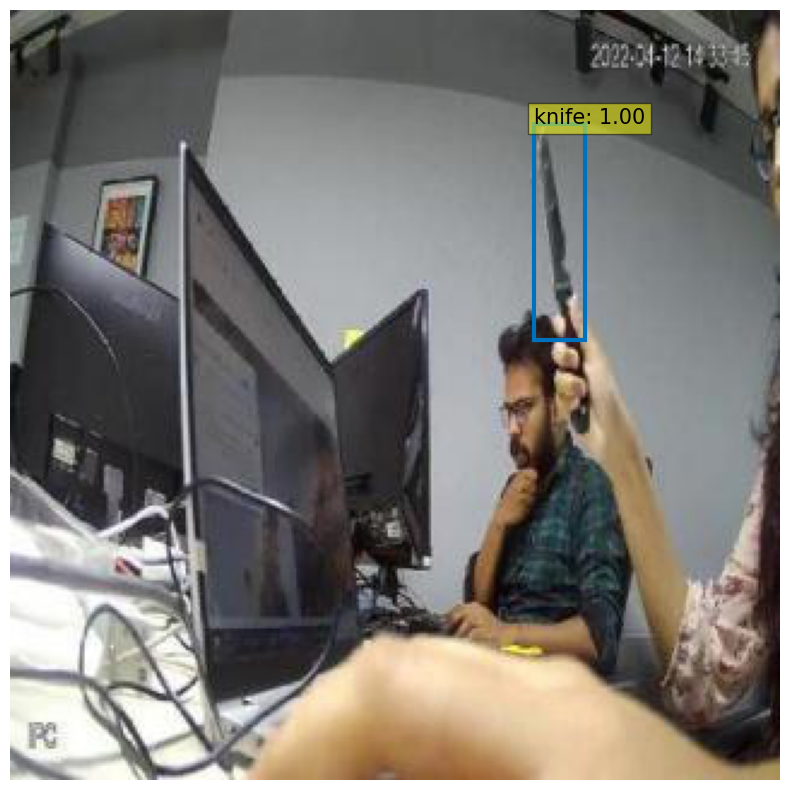

In [48]:
image_id = target['image_id'].item()
image = val_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(dataset.location + '/valid', image['file_name']))

visualize_predictions(image, outputs)

In [49]:
# MORGAN: We can also log our predicted images with bounding boxes to our wandb run
log_image_bboxes_to_wandb(image, outputs, image_name='my_prediction_image')  # MORGAN 
wandb.finish()

Image with bounding boxes logged to your wandb run!


AP_IOU-0.5_all,0.052


# Active Learning with Roboflow for Production Models

Once you have deployed your model, you will inevitably find edge cases where you need to provide additional data to improve your model's performance.

For example, you're counting pills and you realize your training set did not factor in the possibility that someone might have painted fingernails that look like pills. You need to add these as null examples for your model.

We show here how to upload data back to Roboflow for annotation and then the cycle repeats from the top of the notebook.

You may also find training in Roboflow and using [Roboflow Label Assist](https://docs.roboflow.com/annotate/model-assisted-labeling) useful for iterating on your custom dataset.

In [ ]:
#if you got a bad prediction above

#NOTE: you must own the project (and not have used a public Roboflow Universe project)
project.upload(image_path)

In [ ]:
#you may implement active learning rules - for example, you may want to upload when your model finds no objects with confidence greater than 40%
min_box_conf = float("inf")
for box in res:
    if box["score"] < min_box_conf:
        min_box_conf = box["score"]
if min_box_conf < 0.4:
    project.upload(image_path)

In [ ]:
#log into roboflow to label new images in your project
print(project)

## Save model

In [50]:
# move model to device
model.to(device)

# save model to file
torch.save(model.state_dict(), "yolo_model.pt")